In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import necessary libraries

In [ ]:
!pip install -U sentence-transformers
!pip3 install tensorflow_text
!pip install sentencepiece

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import concat
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Concatenate, GRU,Dropout, Lambda, InputLayer, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D,AveragePooling1D
import time
import csv
import tensorflow_text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, f1_score
import plotly
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from scipy.spatial.distance import cosine
% matplotlib inline

#Upload data

In [ ]:
train_data_path = '/content/drive/My Drive/Univer/Diploma/data_tok/train_data_with_vectors.csv'
eval_data_path = '/content/drive/My Drive/Univer/Diploma/data_tok/eval_data_with_vectors.csv'
test_data_path = '/content/drive/My Drive/Univer/Diploma/data_tok/test_data_with_vectors.csv'
train_words_path = '/content/drive/My Drive/Univer/Diploma/data_tok/words_tokens_train.csv'
eval_words_path = '/content/drive/My Drive/Univer/Diploma/data_tok/words_tokens_eval.csv'
test_words_path = '/content/drive/My Drive/Univer/Diploma/data_tok/words_tokens_test.csv'
model_path = '/content/drive/My Drive/Univer/Diploma/data_tok/model_bpe_dip.model'

train_data = pd.read_csv(train_data_path, sep = ',')
eval_data = pd.read_csv(eval_data_path, sep = ',')
test_data = pd.read_csv(test_data_path, sep = ',')
train_words = pd.read_csv(train_words_path, sep = ',')
eval_words = pd.read_csv(eval_words_path, sep = ',')
test_words = pd.read_csv(test_words_path, sep = ',')

In [ ]:
train_labels = np.array(train_data['label'])
eval_labels = np.array(eval_data['label'])
test_labels = np.array(test_data['label'])

#Application SP and tokenization text to subword-tokens + padding

In [ ]:
import sentencepiece as spm

def spm_apply(input_text: list, model_name: str, alpha=0.1, enable_sampling=True, nbest_size=2):
    '''If you use unigram model, you should define the variable model_name = 'm_unigram.model' '''

    sp = spm.SentencePieceProcessor()

    global time

    start_time = time.time()
    sp.load(model_name)
    subword_tokens_list = []
    subword_vectors_list = []


    for text in input_text:
        subword_tokens_list.append(sp.encode_as_pieces(text))
        subword_vectors_list.append(sp.encode(str(text), alpha=0.1))

    end_time = time.time()
    work_time = end_time - start_time
    print(f'Time: {work_time}')
    assert len(subword_tokens_list) > 0
    print(f'List with subword was written successfuly!')
    print(f'Len of input_text: {len(input_text)}')
    print(f'Len of subword_tokens_list: {len(subword_tokens_list)}' + '\n')
    return subword_tokens_list, subword_vectors_list

In [ ]:
#convert DataFrames into lists
train_text_list = []
for i, row in train_data.iterrows():

  train_text_list.append(row['text'])

eval_text_list = []
for i, row in eval_data.iterrows():
  eval_text_list.append(row['text'])

test_text_list = []
for i, row in test_data.iterrows():
  test_text_list.append(row['text'])

Application SP and tokenization text to subword-tokens

In [ ]:
train_tokens, train_vectors = spm_apply(train_text_list, model_path)
eval_tokens, eval_vectors = spm_apply(eval_text_list, model_path)
test_tokens, test_vectors = spm_apply(test_text_list, model_path)

Time: 0.5543966293334961
List with subword was written successfuly!
Len of input_text: 140
Len of subword_tokens_list: 140

Time: 0.03376436233520508
List with subword was written successfuly!
Len of input_text: 123
Len of subword_tokens_list: 123

Time: 0.023512601852416992
List with subword was written successfuly!
Len of input_text: 74
Len of subword_tokens_list: 74



Settings

In [ ]:
MAX_SEQ_LEN = 400
vocab_size = 10000
EMBED_DIM = 512

Padding

In [ ]:
train_vectors_pad = pad_sequences(train_vectors, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
eval_vectors_pad = pad_sequences(eval_vectors, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
test_vectors_pad = pad_sequences(test_vectors, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

print(train_vectors_pad.shape)
print(eval_vectors_pad.shape)
print(test_vectors_pad.shape)

(140, 400)
(123, 400)
(74, 400)


#Extraction of first and second entities from texts for tokenization + padding

 Extraction the vectors from sentencepiece

In [ ]:
def get_words_vectors(data_vectors, vectors_ot_tokens):
  f_w = []
  s_w = []
  start1 = []
  end1 = []
  start2 = []
  end2 = []
  for idx, row in enumerate(data_vectors):
      for i,ex in enumerate(row):
          if ex == 3:
              start1.append(i)
          elif ex == 4:
              end1.append(i)
          elif ex == 5:
              start2.append(i)
          elif ex == 6:
              end2.append(i)

      first_word = []
      second_word = []
      
      for i in range(start1[idx]+1, end1[idx]):
          first_word.append(vectors_ot_tokens[idx][i])

      for j in range(start2[idx]+1, end2[idx]):
          second_word.append(vectors_ot_tokens[idx][j])
          
      f_w.append(first_word)
      s_w.append(second_word)
  return f_w, s_w

In [ ]:
#train entities
f_w_vectors_train, s_w_vectors_train = get_words_vectors(train_vectors, train_vectors)
f_w_tokens_train, s_w_tokens_train = get_words_vectors(train_vectors, train_tokens)

#eval entities
f_w_vectors_eval, s_w_vectors_eval = get_words_vectors(eval_vectors, eval_vectors)
f_w_tokens_eval, s_w_tokens_eval = get_words_vectors(eval_vectors, eval_tokens)

#test entities
f_w_vectors_test, s_w_vectors_test = get_words_vectors(test_vectors, test_vectors)
f_w_tokens_test, s_w_tokens_test = get_words_vectors(test_vectors, test_tokens)

Getting a sequence from the first and second terms

In [ ]:
#A words tokens sequence
w_tokens_train = f_w_tokens_train + s_w_tokens_train
w_tokens_eval = f_w_tokens_eval + s_w_tokens_eval
w_tokens_test = f_w_tokens_test + s_w_tokens_test

#A vectors tokens sequence
w_vectors_train = f_w_vectors_train + s_w_vectors_train
w_vectors_eval = f_w_vectors_eval + s_w_vectors_eval
w_vectors_test = f_w_vectors_test + s_w_vectors_test

Padding

In [ ]:
MAX_SEQ_LEN_words = 10

In [ ]:
train_first_words_pad = pad_sequences(f_w_vectors_train, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')
train_second_words_pad = pad_sequences(s_w_vectors_train, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

eval_first_words_pad = pad_sequences(f_w_vectors_eval, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')
eval_second_words_pad = pad_sequences(s_w_vectors_eval, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

test_first_words_pad = pad_sequences(f_w_vectors_test, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')
test_second_words_pad = pad_sequences(s_w_vectors_test, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

w_vectors_train_pad = pad_sequences(w_vectors_train, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')
w_vectors_eval_pad = pad_sequences(w_vectors_eval, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

print(f'Shape of train first terms:{train_first_words_pad.shape}, second terms: {train_second_words_pad.shape}')
print(f'Shape of eval first terms:{eval_first_words_pad.shape}, second terms: {eval_second_words_pad.shape}')
print(f'Shape of test first terms:{test_first_words_pad.shape}, second terms: {test_second_words_pad.shape}')
print(f'Shape of train all terms:{w_vectors_train_pad.shape}, eval all terms: {w_vectors_eval_pad.shape}')

Shape of train first terms:(140, 10), second terms: (140, 10)
Shape of eval first terms:(123, 10), second terms: (123, 10)
Shape of test first terms:(74, 10), second terms: (74, 10)
Shape of train all terms:(280, 10), eval all terms: (246, 10)


#Embeddings and averaging

Setting embedding, averaging and concatination layers

In [ ]:
model_emb = Embedding(vocab_size,EMBED_DIM)
model_avg = GlobalAveragePooling1D()
model_concat = Concatenate()

Getting embeddings for sentenses and entities. After that the words embeddings are concatenate with sentence's embedding.

In [ ]:
#train embeddings
first_embed = model_emb(train_first_words_pad)
second_embed = model_emb(train_second_words_pad)
sent_emb = model_emb(train_vectors_pad)

#eval embeddings
first_embed_ev = model_emb(eval_first_words_pad)
second_embed_ev = model_emb(eval_second_words_pad)
sent_emb_ev = model_emb(eval_vectors_pad)

#averaging train
first_avg = model_avg(first_embed)
second_avg = model_avg(second_embed)
sent_avg = model_avg(sent_emb)

#averaging eval
first_avg_ev = model_avg(first_embed_ev)
second_avg_ev = model_avg(second_embed_ev)
sent_avg_ev = model_avg(sent_emb_ev)

In [ ]:
#concatination train
sent_e = np.array(sent_emb)
f_e = np.array(first_embed)
s_e = np.array(second_embed)
ayf = np.concatenate([sent_e,f_e,s_e], axis = 1)

#concatination eval
sent_e_ev = np.array(sent_emb_ev)
f_e_ev = np.array(first_embed_ev)
s_e_ev = np.array(second_embed_ev)
ayf_ev = np.concatenate([sent_e_ev,f_e_ev,s_e_ev], axis = 1)

#GRU for concatination sequences

In [ ]:
model_words = Sequential([
                InputLayer(input_shape=(MAX_SEQ_LEN+2*MAX_SEQ_LEN_words,EMBED_DIM,), dtype='float32'),
                Dropout(0.5),
                GRU(512, recurrent_dropout=0.2),
                Dropout(0.5),
                Dense(512, activation='relu'),
                Dense(128, activation='relu'),
                Dense(1, activation='sigmoid')])

model_words.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model_words.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_16 (Dropout)         (None, 420, 512)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 1,904,385
Trainable params: 1,904,385
Non-trainable params: 0
____________________________________________

In [ ]:
model_words.fit(ayf, 
            train_labels,
            epochs=10,
            batch_size=32)

Epoch 1/10
5/5 [==============================] - 56s 11s/step - loss: 0.6953 - accuracy: 0.4571
Epoch 2/10
5/5 [==============================] - 55s 11s/step - loss: 0.6961 - accuracy: 0.5357
Epoch 3/10
5/5 [==============================] - 56s 11s/step - loss: 0.6965 - accuracy: 0.5357
Epoch 4/10
5/5 [==============================] - 55s 11s/step - loss: 0.6895 - accuracy: 0.5429
Epoch 5/10
5/5 [==============================] - 55s 11s/step - loss: 0.6849 - accuracy: 0.5714
Epoch 6/10
5/5 [==============================] - 55s 11s/step - loss: 0.6892 - accuracy: 0.5214
Epoch 7/10
5/5 [==============================] - 55s 11s/step - loss: 0.6815 - accuracy: 0.5857
Epoch 8/10
5/5 [==============================] - 55s 11s/step - loss: 0.6689 - accuracy: 0.5857
Epoch 9/10
5/5 [==============================] - 55s 11s/step - loss: 0.6762 - accuracy: 0.5786
Epoch 10/10
5/5 [==============================] - 55s 11s/step - loss: 0.6353 - accuracy: 0.5714


In [ ]:
y_pred_gru = model_words.predict(ayf_ev)
#print(f1_score(eval_labels, y_pred_gru))
#print(classification_report(eval_labels, y_pred_gru[0]))

In [ ]:
li = []
for i in y_pred_gru:
  if i >=0.30:
    li.append(1)
  else:
    li.append(0)

In [ ]:
print(f1_score(eval_labels, li))

0.358974358974359


Getting terms without tokenization

In [ ]:
train_words_list = []
for i in w_tokens_train:
  word = ",".join(i).replace(',', '')
  train_words_list.append(word)

train_first_words_list = []
for i in f_w_tokens_train:
  word = ",".join(i).replace(',', '')
  train_first_words_list.append(word)

train_second_words_list = []
for i in s_w_tokens_train:
  word = ",".join(i).replace(',', '')
  train_second_words_list.append(word)

print(len(train_words_list), len(train_first_words_list), len(train_second_words_list))

#Neural Networks

In [ ]:
train_labels_ = np.reshape(train_labels, (140,1))
eval_labels_ = np.reshape(eval_labels, (len(eval_labels),1))

**CNN**

In [ ]:
def CNN(EMBED_DIM, vocab_size):
    model = Sequential([
    InputLayer(input_shape=(MAX_SEQ_LEN+2*MAX_SEQ_LEN_words,EMBED_DIM,), dtype='float32'),
    Dropout(0.5),
    Conv1D(512, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(3),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation = 'sigmoid')])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model
model_spm_all = CNN(EMBED_DIM, vocab_size)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_24 (Dropout)         (None, 420, 512)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 418, 512)          786944    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 139, 512)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 137, 128)          196736    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 45, 128)           0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)             

In [ ]:
model_spm_all.fit(ayf, 
            train_labels,
            epochs=10,
            batch_size=32)

Epoch 1/10
5/5 [==============================] - 5s 832ms/step - loss: 0.7018 - accuracy: 0.4643
Epoch 2/10
5/5 [==============================] - 4s 829ms/step - loss: 0.7025 - accuracy: 0.4857
Epoch 3/10
5/5 [==============================] - 4s 818ms/step - loss: 0.6970 - accuracy: 0.5143
Epoch 4/10
5/5 [==============================] - 4s 818ms/step - loss: 0.6928 - accuracy: 0.4786
Epoch 5/10
5/5 [==============================] - 4s 817ms/step - loss: 0.6926 - accuracy: 0.5429
Epoch 6/10
5/5 [==============================] - 4s 811ms/step - loss: 0.7043 - accuracy: 0.4857
Epoch 7/10
5/5 [==============================] - 4s 816ms/step - loss: 0.6902 - accuracy: 0.5000
Epoch 8/10
5/5 [==============================] - 4s 819ms/step - loss: 0.6949 - accuracy: 0.5143
Epoch 9/10
5/5 [==============================] - 4s 821ms/step - loss: 0.6949 - accuracy: 0.5071
Epoch 10/10
5/5 [==============================] - 4s 814ms/step - loss: 0.6810 - accuracy: 0.6143


In [ ]:
y_pred_cnn = model_spm_all.predict(eval_vectors_pad)
print(f1_score(eval_labels_, y_pred_cnn))
print(classification_report(eval_labels_, y_pred_cnn))

**RNN (GRU)**

In [ ]:
def RNN_GRU(MAX_SEQ_LEN, EMBED_DIM, vocab_size):
    nclasses = 2
    model = Sequential()
    hidden_layer = 3
    gru_node = 32

    model.add(InputLayer(input_shape=(MAX_SEQ_LEN+2*MAX_SEQ_LEN_words,EMBED_DIM,), dtype='float32'))
    model.add(Dropout(0.5))
    model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    model.summary
    return model
model_spm_all_rnn = RNN_GRU(MAX_SEQ_LEN, EMBED_DIM, vocab_size)

In [ ]:
model_spm_all_rnn.fit(ayf, 
            train_labels,
            epochs=20,
            batch_size=32)

Epoch 1/20
5/5 [==============================] - 9s 907ms/step - loss: 0.6933 - accuracy: 0.5357
Epoch 2/20
5/5 [==============================] - 5s 911ms/step - loss: 0.6923 - accuracy: 0.5143
Epoch 3/20
5/5 [==============================] - 4s 884ms/step - loss: 0.6926 - accuracy: 0.5429
Epoch 4/20
5/5 [==============================] - 5s 912ms/step - loss: 0.6931 - accuracy: 0.5214
Epoch 5/20
5/5 [==============================] - 5s 906ms/step - loss: 0.6908 - accuracy: 0.5643
Epoch 6/20
5/5 [==============================] - 5s 905ms/step - loss: 0.6866 - accuracy: 0.5714
Epoch 7/20
5/5 [==============================] - 5s 909ms/step - loss: 0.6910 - accuracy: 0.5643
Epoch 8/20
5/5 [==============================] - 5s 918ms/step - loss: 0.6866 - accuracy: 0.5643
Epoch 9/20
5/5 [==============================] - 5s 896ms/step - loss: 0.6870 - accuracy: 0.5643
Epoch 10/20
5/5 [==============================] - 5s 899ms/step - loss: 0.6842 - accuracy: 0.5643
Epoch 11/20
5/5 [==

In [ ]:
y_pred_rnn_gru = model_spm_all_rnn.predict(eval_vectors_pad)
print(f1_score(eval_labels_, y_pred_rnn_gru))
print(classification_report(eval_labels_, y_pred_rnn_gru))

**Bidirectional LSTM**

In [ ]:
def RNN_LSTM(MAX_SEQ_LEN, EMBED_DIM, vocab_size):
  model = Sequential([
    InputLayer(input_shape=(MAX_SEQ_LEN+2*MAX_SEQ_LEN_words,EMBED_DIM,), dtype='float32'),
    Dropout(0.5),
    Bidirectional(LSTM(1000)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'softmax')])

  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  model.summary()

  return model
m1 = RNN_LSTM(MAX_SEQ_LEN, EMBED_DIM, vocab_size)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_37 (Dropout)         (None, 420, 512)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2000)              12104000  
_________________________________________________________________
dense_51 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_55 (Dense)             (None, 32)              

In [ ]:
m1.fit(ayf, 
            train_labels,
            epochs=10,
            batch_size=32)

In [ ]:
y_pred_bilstm = m1.predict(eval_vectors_pad)
print(f1_score(eval_labels_, y_pred_bilstm))
print(classification_report(eval_labels_, y_pred_bilstm))

**CNN+LSTM**

In [ ]:
def CNN_LSTM(MAX_SEQ_LEN, vocab_size, EBMED_DIM):
  kernel_size = 2
  filters = 256
  pool_size = 2
  gru_node = 256
  model = Sequential()

  model.add(InputLayer(input_shape=(MAX_SEQ_LEN+2*MAX_SEQ_LEN_words,EMBED_DIM,), dtype='float32'))
  model.add(Dropout(0.5))
  model.add(Conv1D(filters, kernel_size, activation='relu'))
  model.add(MaxPooling1D(pool_size=pool_size))
  model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
  model.add(LSTM(gru_node, recurrent_dropout=0.5))
  model.add(Dense(1024,activation='relu'))
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  model.summary()
  return model

m2 = CNN_LSTM(MAX_SEQ_LEN, vocab_size, EMBED_DIM)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_46 (Dropout)         (None, 420, 512)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 419, 256)          262400    
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 209, 256)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 209, 256)          525312    
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_75 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_76 (Dense)             (None, 512)             

In [ ]:
m2.fit(ayf, 
            train_labels,
            epochs=10,
            batch_size=32)

Epoch 1/10
5/5 [==============================] - 25s 4s/step - loss: 0.6951 - accuracy: 0.5143
Epoch 2/10
5/5 [==============================] - 21s 4s/step - loss: 0.7000 - accuracy: 0.5071
Epoch 3/10
5/5 [==============================] - 21s 4s/step - loss: 0.6949 - accuracy: 0.4571
Epoch 4/10
5/5 [==============================] - 21s 4s/step - loss: 0.6942 - accuracy: 0.4929
Epoch 5/10
5/5 [==============================] - 21s 4s/step - loss: 0.6924 - accuracy: 0.4714
Epoch 6/10
5/5 [==============================] - 21s 4s/step - loss: 0.6932 - accuracy: 0.5143
Epoch 7/10
5/5 [==============================] - 21s 4s/step - loss: 0.6913 - accuracy: 0.5214
Epoch 8/10
5/5 [==============================] - 21s 4s/step - loss: 0.6826 - accuracy: 0.5286
Epoch 9/10
5/5 [==============================] - 21s 4s/step - loss: 0.6414 - accuracy: 0.5786
Epoch 10/10
5/5 [==============================] - 21s 4s/step - loss: 0.5977 - accuracy: 0.7143


In [ ]:
y_pred_cnnlstm = m2.predict(ayf_ev)
# print(f1_score(eval_labels_, y_pred_cnnlstm))
# print(classification_report(eval_labels_, y_pred_cnnlstm))

#**Visualisation**

In [ ]:
avg = GlobalAveragePooling1D()
avg_w = avg(embed_w)
avg_res = np.reshape(avg_w, (280,1,300))

In [ ]:
new = []
for i in w_tokens_train:
  a = ",".join(i).replace(',', '').replace('▁',' ')
  new.append([a])

In [ ]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, metric="cosine")
embedding_clusters = np.array(avg_res)
n, m, k = avg_res.shape
embeddings_en_2d_4 = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

No handles with labels found to put in legend.


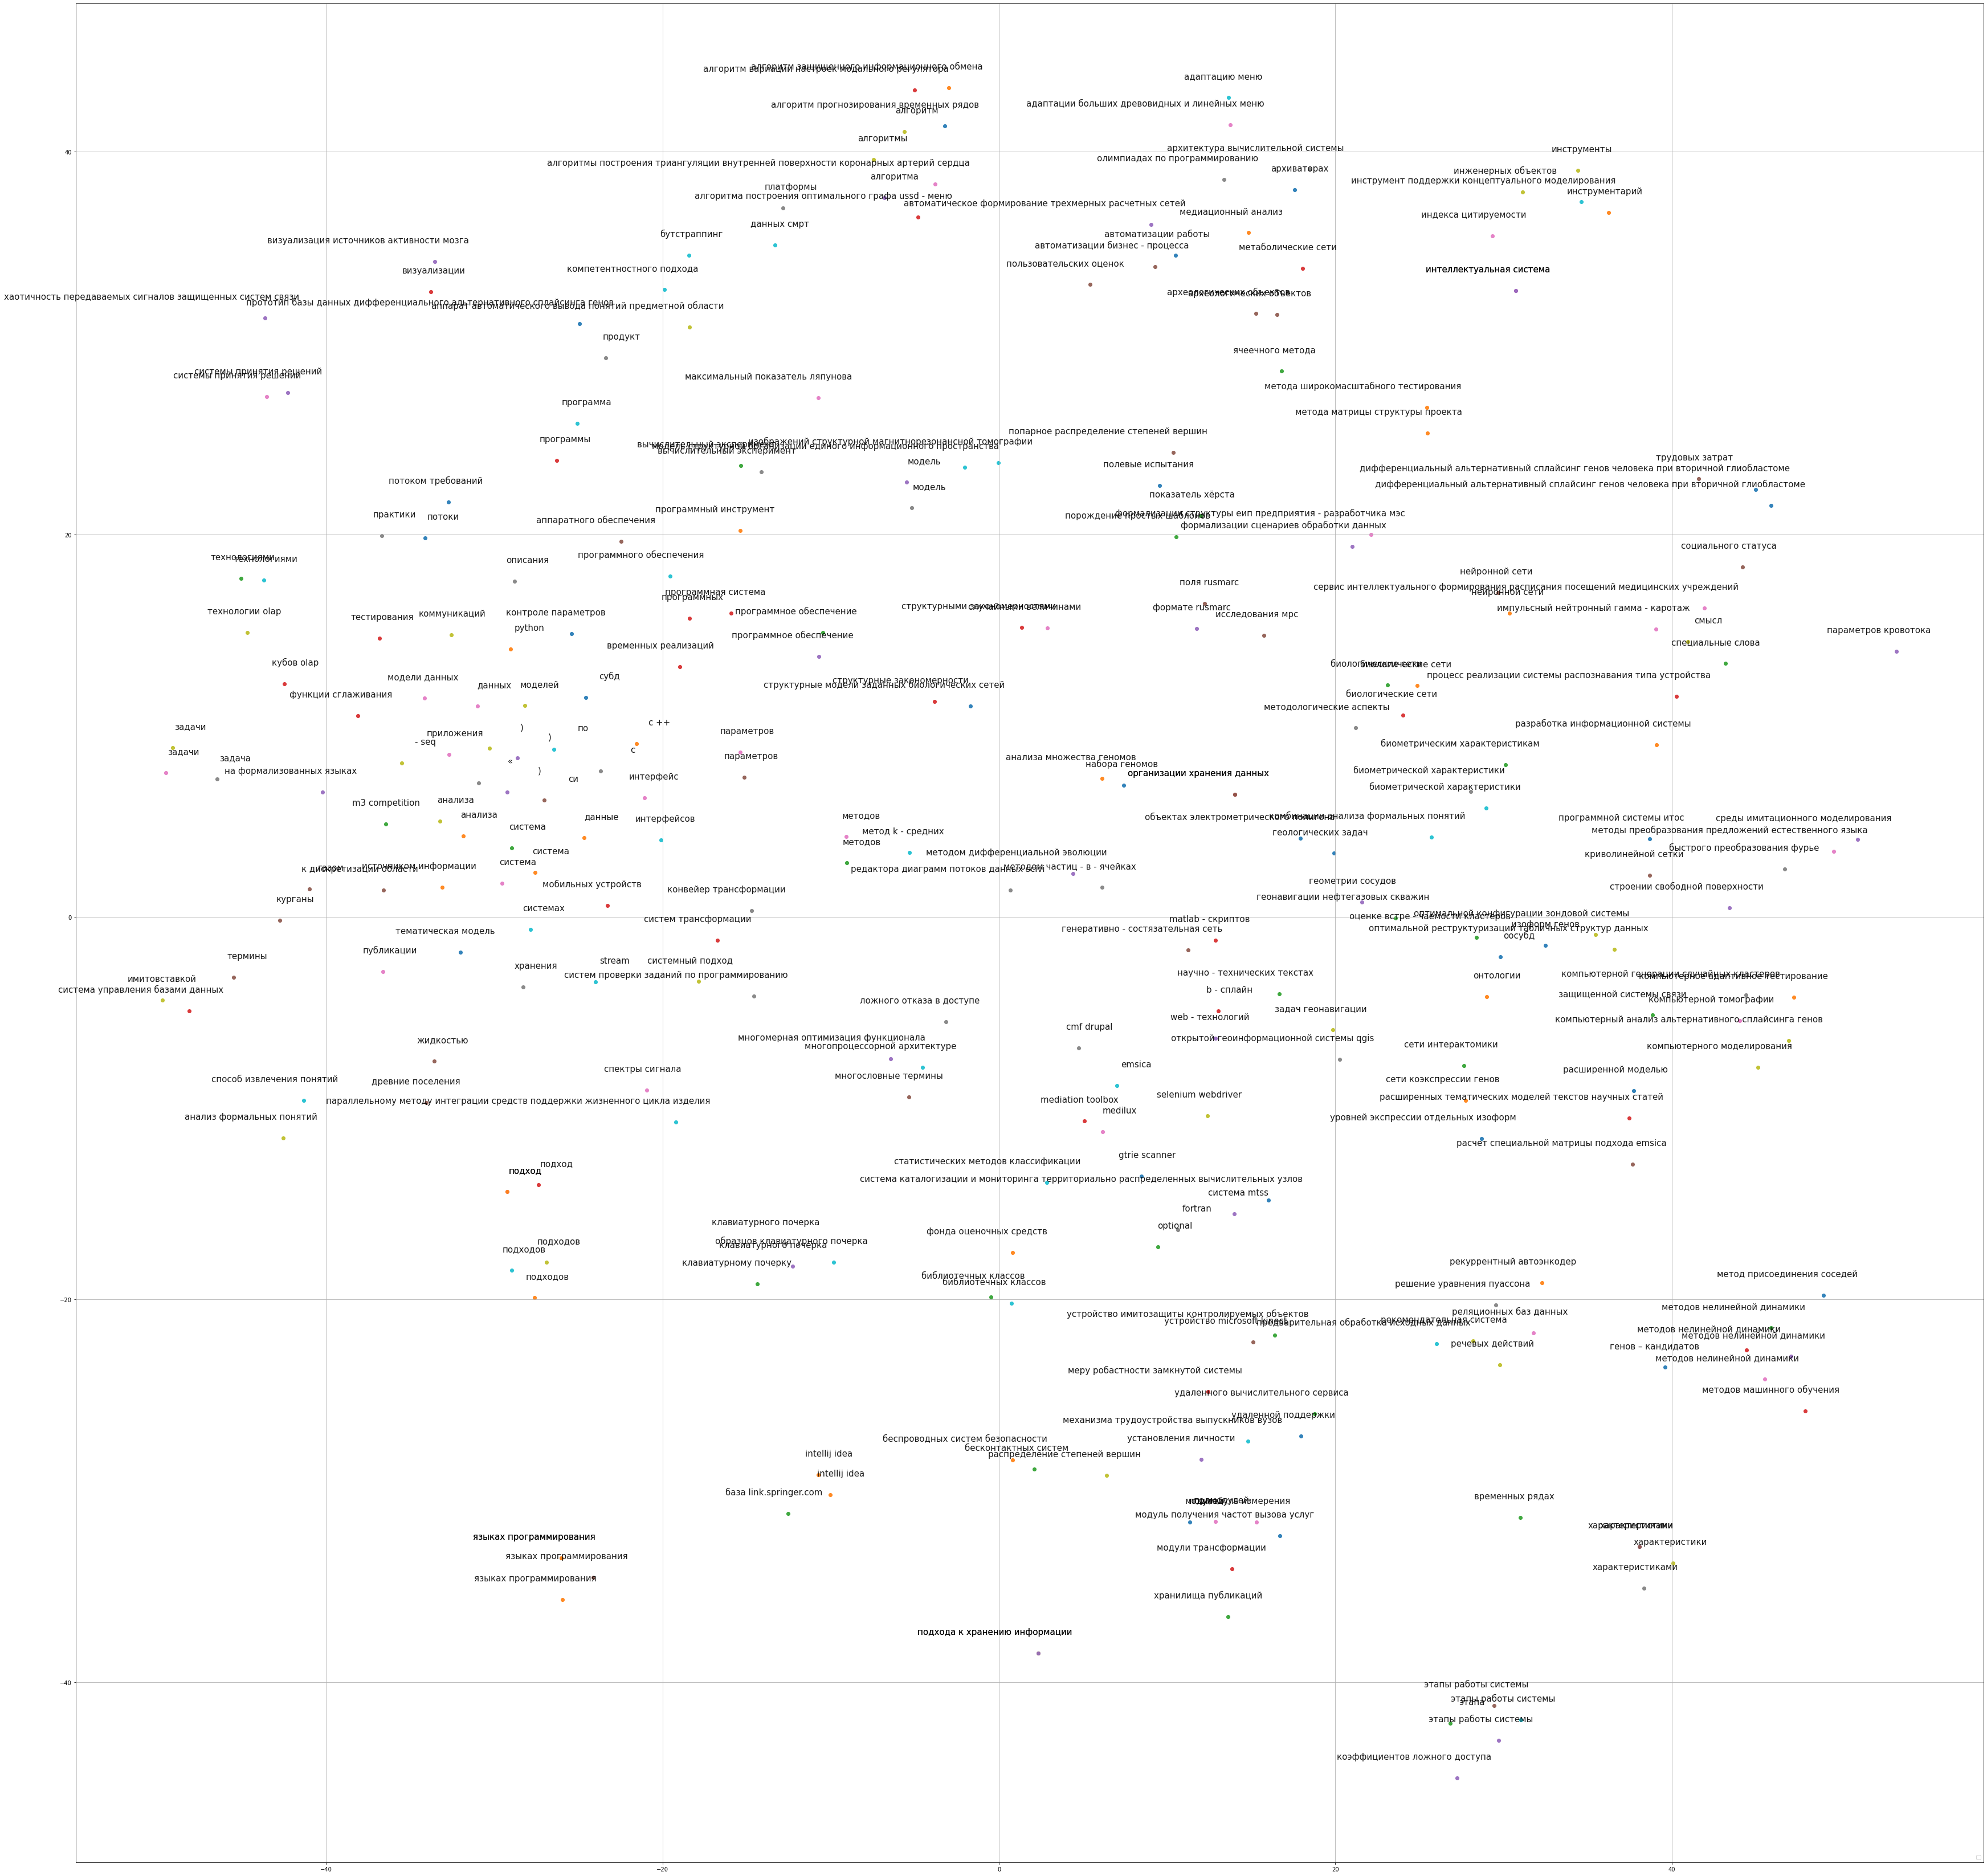

In [ ]:
def tsne_plot_similar_words(embedding_clusters, word_clusters, a=0.9):
    plt.figure(figsize=(60, 60))
    #colors = cm.rainbow(np.linspace(0, 1))
    for embeddings, words in zip(embedding_clusters, word_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, alpha=a)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.9, xy=(x[i], y[i]), xytext=(60, 30), 
                         textcoords='offset points', ha='right', va='bottom', size=15)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("/content/drive/My Drive/Univer/Diploma/data_tok/graphs5.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(embeddings_en_2d_4, new)
